In [1]:
#importing liberies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
# Load and inspect dataset

df = pd.read_csv("Parishousing.csv")

print(df.sample(5))
print(df.info())
print(df.describe())

      squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
1658         21104             12        0        1      86     21135   
9021         52078             17        0        1       1     53361   
3886         91482             86        1        0      32     90465   
5551         52655             82        0        0       6     64588   
7147         37729             90        0        0      16     87392   

      cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
1658              8              6  2008           0                  0   
9021              4              6  1993           1                  1   
3886              6              2  2003           1                  0   
5551              4              4  1990           1                  0   
7147              1              5  1993           1                  0   

      basement  attic  garage  hasStorageRoom  hasGuestRoom      price  
1658      8164   7067     194        

In [4]:
#Checking for nulls
df.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

In [5]:
# Target distribution
import seaborn as sns

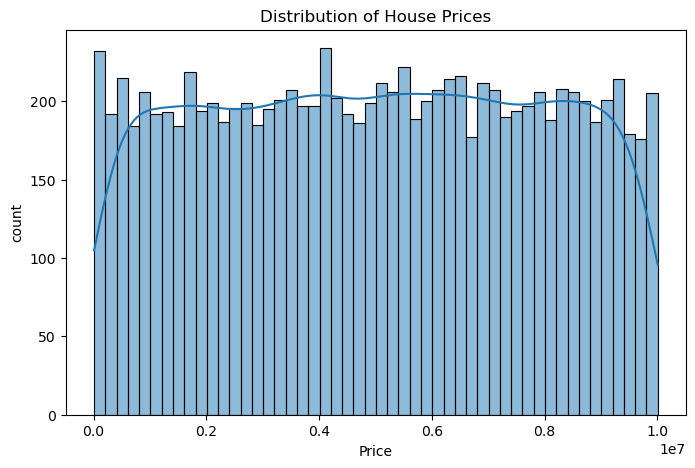

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('count')
plt.show()

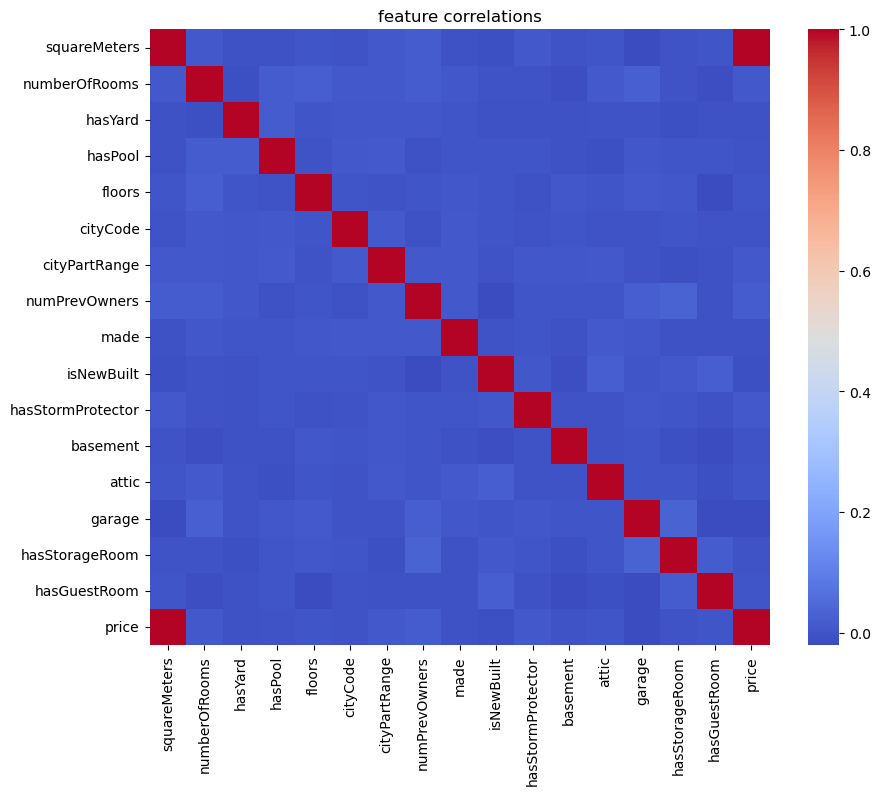

In [7]:
# correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('feature correlations')
plt.show()
           

In [8]:
### Feature Engineering

# create house age
CURRENT_YEAR = 2025
df['house_age'] = CURRENT_YEAR - df['made']

#drop original made
df = df.drop(columns=['made'])

# feature list
all_features = [c for c in df.columns if c !='price']
print('All_Features:', all_features)

All_Features: ['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners', 'isNewBuilt', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'house_age']


In [9]:
df.house_age

0       20
1       10
2        4
3       13
4       35
        ..
9995    16
9996    35
9997    20
9998    15
9999    31
Name: house_age, Length: 10000, dtype: int64

In [10]:
# Train/ test split
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size =0.20, random_state=42
)

In [11]:
# scaling with columnTransformers and onehot encoder

categorical_features = ['cityCode', 'cityPartRange']
numeric_features = [c for c in X.columns if c not in categorical_features]

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [12]:
# define pipelines for model

# linear Regression pipeline
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('model', LinearRegression())
])

# Decision Tree pipeline 
pipe_dt = Pipeline([
    ('pre', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Random Forest pipeline
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [13]:
# using Helper function to evaluate and train model

def evaluate_model(pipeline, X_train, y_train, X_test, y_test, name='model'):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    print(f'{name} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}')
    return {'name': name, 'mse': mse, 'rmse':rmse, 'r2':r2, 'preds':preds}

results = []
results.append(evaluate_model(pipe_lr, X_train, y_train, X_test, y_test, 'LinearRegression'))
results.append(evaluate_model(pipe_dt, X_train, y_train, X_test, y_test, 'DecisionTree'))
results.append(evaluate_model(pipe_rf, X_train, y_train, X_test, y_test, 'RandomForest'))

LinearRegression -> MSE: 4113687.35, RMSE: 2028.22, R2: 1.00
DecisionTree -> MSE: 31462792.54, RMSE: 5609.17, R2: 1.00
RandomForest -> MSE: 15765930.01, RMSE: 3970.63, R2: 1.00


In [14]:
# Using cross-validation for each model

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print('RandomForest CV R2 mean:', cv_scores.mean())

RandomForest CV R2 mean: 0.9999980740040104


In [15]:
# checking for dataleak

correlations = df.corr(numeric_only=True)['price'].sort_values(ascending=False)
print(correlations)


price                1.000000
squareMeters         0.999999
numPrevOwners        0.016619
numberOfRooms        0.009591
cityPartRange        0.008813
hasStormProtector    0.007496
house_age            0.007210
floors               0.001654
attic               -0.000600
hasGuestRoom        -0.000644
cityCode            -0.001539
hasStorageRoom      -0.003485
basement            -0.003967
hasPool             -0.005070
hasYard             -0.006119
isNewBuilt          -0.010643
garage              -0.017229
Name: price, dtype: float64


               name           mse         rmse        r2
0  LinearRegression  4.113687e+06  2028.222707  1.000000
2      RandomForest  1.576593e+07  3970.633452  0.999998
1      DecisionTree  3.146279e+07  5609.170397  0.999996


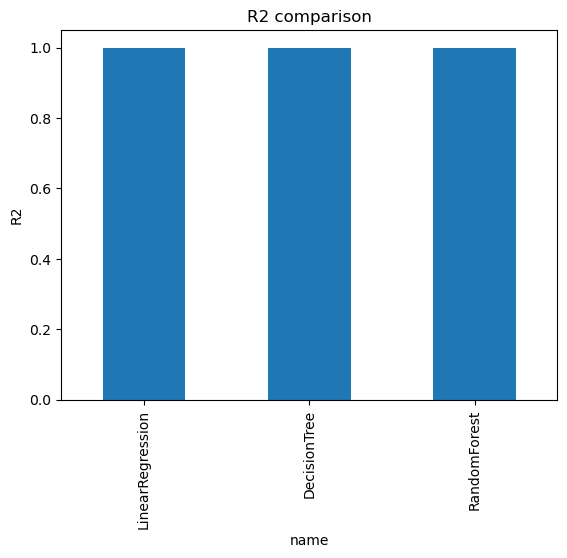

In [17]:
# compare models in atable

res_df = pd.DataFrame([{'name':r['name'],'mse':r['mse'],'rmse':r['rmse'],'r2':r['r2']} for r in results])
print(res_df.sort_values('r2', ascending=False))

# bar plot for R2
res_df.set_index('name')['r2'].plot(kind='bar', title='R2 comparison')
plt.ylabel('R2')
plt.show()

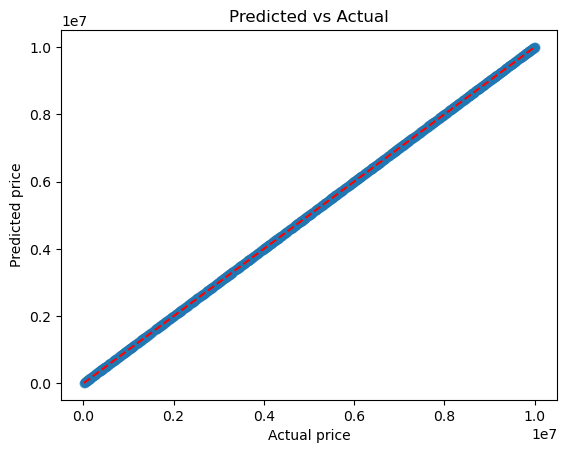

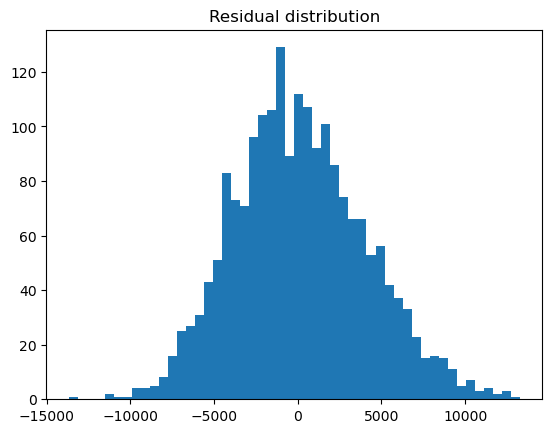

In [18]:
#Diagnostics (residuals, preds vs actual)

# choose model
model = best_rf if 'best_rf' in globals() else pipe_rf
preds = model.predict(X_test)

# predicted vs actual
plt.scatter(y_test, preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Predicted vs Actual")
plt.show()

# residual histogram
residuals = y_test - preds
plt.hist(residuals, bins=50)
plt.title("Residual distribution")
plt.show()


In [20]:
##Save the best model
import joblib

joblib.dump(pipe_rf, "best_house_price_model.joblib")




['best_house_price_model.joblib']